In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
import torchvision
import torch.optim as optim
import argparse
import matplotlib
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.utils import save_image
import pandas as pd
import numpy as np
matplotlib.style.use('ggplot')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.model_selection import KFold
import copy

c:\Users\mdzak\anaconda3\envs\fyp\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Import CSV and merge with drugs

In [2]:
selected_dim = 512
dimension = pd.read_csv('../results/results' + str(selected_dim) + 'D_latent_space_gene_exp.tsv',sep='\t')
cell_line_name = pd.read_csv('../results_clean/cell_line_name.csv')
gdsc_drug = pd.read_csv('../results_clean/gdsc_drug_nodash.csv')
dimension.drop(columns=['Unnamed: 0'], inplace=True)
gdsc_drug.drop(columns=['Unnamed: 0'], inplace= True)
dimension['CELL_LINE_NAME'] = cell_line_name['CELL_LINE_NAME']
dimension_w_drug = pd.merge(dimension, gdsc_drug, on='CELL_LINE_NAME')
dimension_w_drug.drop(columns=['CELL_LINE_NAME'],inplace=True)
# dimension_w_drug = pd.get_dummies(dimension_w_drug, columns=['DRUG_NAME'])

In [3]:
dimension_w_drug = dimension_w_drug.sample(frac=1, random_state=33).reset_index(drop=True)
dimension_w_drug

,0,1,2,3,4,5,6,7,8,9,...,504,505,506,507,508,509,510,511,LN_IC50,DRUG_NAME
0,-0.000051,-0.000019,-0.000011,0.000024,0.000007,-8.061088e-07,0.000007,-0.000022,-0.000001,-6.285769e-07,...,2.554270e-05,-0.000027,-0.000006,-0.000015,-0.000009,-2.313422e-09,-0.000030,-0.000006,2.686879,LGK974
1,0.000016,0.000019,0.000021,-0.000020,-0.000019,8.401084e-06,-0.000008,0.000007,0.000005,7.881104e-06,...,1.326165e-05,0.000016,0.000007,0.000022,-0.000011,5.558876e-06,-0.000009,0.000017,5.515893,5-azacytidine
2,0.000018,0.000013,0.000014,-0.000018,-0.000027,1.120291e-05,-0.000017,0.000010,-0.000017,1.261873e-05,...,8.616230e-06,0.000012,-0.000004,0.000008,-0.000029,6.588442e-06,-0.000015,0.000025,2.400499,Sorafenib
3,0.000025,0.000017,0.000019,-0.000018,-0.000007,2.656029e-06,-0.000001,0.000007,-0.000006,-3.416440e-07,...,1.610182e-05,0.000016,0.000001,0.000016,-0.000014,5.584157e-06,0.000001,0.000003,3.499021,PRT062607
4,0.000015,0.000011,0.000009,-0.000020,-0.000026,1.035570e-05,-0.000018,0.000009,-0.000029,1.117597e-05,...,6.395610e-06,0.000010,-0.000021,0.000006,-0.000021,9.252887e-06,-0.000016,0.000022,2.639762,AZD5438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157613,0.000021,0.000018,0.000020,-0.000017,-0.000013,4.705978e-06,-0.000004,0.000007,-0.000012,2.477079e-06,...,2.335720e-05,0.000016,-0.000009,0.000017,-0.000013,7.115398e-06,-0.000008,0.000007,2.482369,AGK2
157614,0.000010,0.000011,0.000013,-0.000023,-0.000008,5.049877e-06,-0.000003,0.000009,-0.000022,2.451690e-06,...,1.057978e-05,0.000010,-0.000002,0.000010,0.000011,8.473494e-06,-0.000012,0.000009,2.919147,Cisplatin
157615,0.000032,0.000021,0.000020,-0.000015,-0.000007,2.048283e-06,-0.000002,0.000009,0.000014,-2.901634e-07,...,1.027891e-05,0.000022,0.000006,0.000022,-0.000024,2.136412e-06,0.000014,0.000002,4.440038,Serdemetan
157616,0.000023,0.000011,0.000006,-0.000013,-0.000024,9.110397e-06,-0.000014,0.000012,-0.000014,1.102952e-05,...,-9.822003e-06,0.000010,0.000003,0.000003,-0.000027,1.096455e-06,-0.000004,0.000020,3.617427,ABT737


### Seperate continuous and categorical columns

In [4]:
cat_cols = ['DRUG_NAME']
cont_cols = dimension_w_drug.drop(columns=['DRUG_NAME', 'LN_IC50']).columns
label_cols = ['LN_IC50']

In [5]:
cont_cols

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9',
       ...
       '502', '503', '504', '505', '506', '507', '508', '509', '510', '511'],
      dtype='object', length=512)

In [6]:
cat_cols

['DRUG_NAME']

### Categorify

In [7]:
for cat in cat_cols:
    dimension_w_drug[cat] = dimension_w_drug[cat].astype('category')

In [8]:
dimension_w_drug.dtypes

0             float64
1             float64
2             float64
3             float64
4             float64
               ...   
509           float64
510           float64
511           float64
LN_IC50       float64
DRUG_NAME    category
Length: 514, dtype: object

In [9]:
dimension_w_drug['DRUG_NAME'].head()

0           LGK974
1    5-azacytidine
2        Sorafenib
3        PRT062607
4          AZD5438
Name: DRUG_NAME, dtype: category
Categories (286, object): ['123138', '123829', '150412', '5-Fluorouracil', ..., 'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)', 'glutathione']

In [10]:
dimension_w_drug['DRUG_NAME'].cat.categories

Index(['123138', '123829', '150412', '5-Fluorouracil', '5-azacytidine',
       '50869', '615590', '630600', '667880', '720427',
       ...
       'WZ4003', 'Wee1 Inhibitor', 'Wnt-C59', 'XAV939', 'YK-4-279', 'ZM447439',
       'Zoledronate', 'alpha-lipoic acid', 'ascorbate (vitamin C)',
       'glutathione'],
      dtype='object', length=286)

In [11]:
drug_name = dimension_w_drug['DRUG_NAME'].cat.codes.values

In [12]:
cats = np.stack([drug_name],1)
cats = torch.tensor(cats, dtype=torch.int64)

In [13]:
cats

tensor([[146],
        [  4],
        [237],
        ...,
        [235],
        [ 16],
        [168]])

### Continuous variables to tensor

In [14]:
conts = np.stack([dimension_w_drug[col].values for col in cont_cols], 1)
conts = torch.tensor(conts, dtype=torch.float)
conts

tensor([[-5.0791e-05, -1.8636e-05, -1.1005e-05,  ..., -2.3134e-09,
         -2.9915e-05, -6.4728e-06],
        [ 1.6457e-05,  1.9499e-05,  2.1097e-05,  ...,  5.5589e-06,
         -9.2284e-06,  1.6989e-05],
        [ 1.8066e-05,  1.3231e-05,  1.3796e-05,  ...,  6.5884e-06,
         -1.5191e-05,  2.4550e-05],
        ...,
        [ 3.2346e-05,  2.0885e-05,  2.0004e-05,  ...,  2.1364e-06,
          1.3795e-05,  1.9565e-06],
        [ 2.2825e-05,  1.0897e-05,  6.3073e-06,  ...,  1.0965e-06,
         -4.1473e-06,  2.0496e-05],
        [ 1.8422e-05,  1.1132e-05,  9.2607e-06,  ...,  7.1955e-06,
         -1.6441e-05,  2.3106e-05]])

### Labels to tensor

In [15]:
labels = np.stack([dimension_w_drug[col].values for col in label_cols], 1)
labels = torch.tensor(labels, dtype=torch.float)
labels

tensor([[2.6869],
        [5.5159],
        [2.4005],
        ...,
        [4.4400],
        [3.6174],
        [4.5057]])

### Embedding size

In [16]:
cat_szs = [len(dimension_w_drug[col].cat.categories) for col in cat_cols]
emb_szs = [(size, min(50, (size+1)//2)) for size in cat_szs]
emb_szs

[(286, 50)]

### Define model

In [17]:
class TabularModel(nn.Module):

    def __init__(self, emb_szs, n_cont, out_sz, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(p)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        
        layerlist = []
        n_emb = sum((nf for ni,nf in emb_szs))
        n_in = n_emb + n_cont
        
        for i in layers:
            layerlist.append(nn.Linear(n_in,i)) 
            layerlist.append(nn.ReLU(inplace=True))
            layerlist.append(nn.BatchNorm1d(i))
            layerlist.append(nn.Dropout(p))
            n_in = i
        layerlist.append(nn.Linear(layers[-1],out_sz))
            
        self.layers = nn.Sequential(*layerlist)
    
    def forward(self, x_cat, x_cont):
        embeddings = []
        for i,e in enumerate(self.embeds):
            embeddings.append(e(x_cat[:,i]))
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        
        x_cont = self.bn_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

In [18]:
torch.manual_seed(33)
model = TabularModel(emb_szs, conts.shape[1], 1, [200,100], p=0.4)

In [19]:
model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(286, 50)
  )
  (emb_drop): Dropout(p=0.4, inplace=False)
  (bn_cont): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=562, out_features=200, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=200, out_features=100, bias=True)
    (5): ReLU(inplace=True)
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Loss and Optimizer Function

In [20]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
torch.cuda.get_device_name(0) # Get name device with ID '0'

'NVIDIA GeForce RTX 3060'

### Perform train/test splits

In [22]:
batch_size = conts.shape[0]
test_size = int(batch_size * .2)

cat_train = cats[:batch_size-test_size]
cat_test = cats[batch_size-test_size:batch_size]
con_train = conts[:batch_size-test_size]
con_test = conts[batch_size-test_size:batch_size]
y_train = labels[:batch_size-test_size]
y_test = labels[batch_size-test_size:batch_size]

In [23]:
con_train.shape

torch.Size([126095, 512])

In [24]:
y_test

tensor([[-0.0142],
        [ 1.1932],
        [ 2.3768],
        ...,
        [ 4.4400],
        [ 3.6174],
        [ 4.5057]])

In [25]:
y_train

tensor([[ 2.6869],
        [ 5.5159],
        [ 2.4005],
        ...,
        [-1.4227],
        [ 5.0628],
        [-6.8808]])

### Train model

In [26]:
import time
start_time = time.time()

epochs = 500
losses = []

for i in range(epochs):
    i+=1
    y_pred = model(cat_train, con_train)
    loss = torch.sqrt(loss_fn(y_pred, y_train)) # RMSE
    losses.append(loss.item())
    
    # a neat trick to save screen space:
    if i%25 == 1:
        print(f'epoch: {i:3}  loss: {loss.item():10.8f}')

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

print(f'epoch: {i:3}  loss: {loss.item():10.8f}') # print the last line
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed

epoch:   1  loss: 4.13804913
epoch:  26  loss: 3.54469013
epoch:  51  loss: 3.21610308
epoch:  76  loss: 2.81680274
epoch: 101  loss: 2.38200808
epoch: 126  loss: 2.11907411
epoch: 151  loss: 1.99756217
epoch: 176  loss: 1.92833459
epoch: 201  loss: 1.86625612
epoch: 226  loss: 1.82701492
epoch: 251  loss: 1.78217566
epoch: 276  loss: 1.75794542
epoch: 301  loss: 1.72819138
epoch: 326  loss: 1.70585978
epoch: 351  loss: 1.69262433
epoch: 376  loss: 1.66731358
epoch: 401  loss: 1.65378308
epoch: 426  loss: 1.64356422
epoch: 451  loss: 1.62647772
epoch: 476  loss: 1.61453819
epoch: 500  loss: 1.60594273

Duration: 815 seconds


### Plot loss function

Text(0.5, 0, 'epoch')

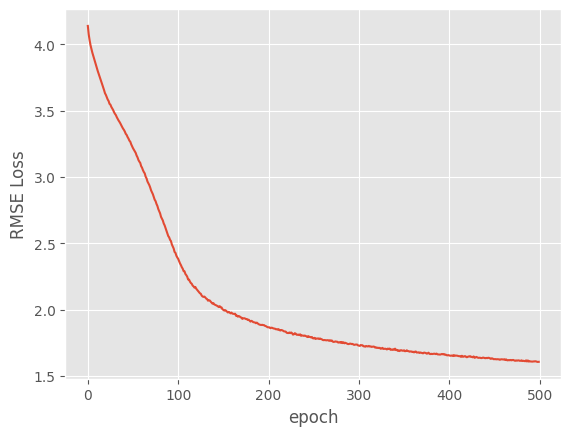

In [28]:
plt.plot(range(epochs), losses)
plt.ylabel('RMSE Loss')
plt.xlabel('epoch')

### Validate Model

In [29]:
with torch.no_grad():
    y_val = model(cat_test, con_test)
    loss = torch.sqrt(loss_fn(y_val, y_test))
print(f'RMSE: {loss:.8f}')

RMSE: 1.61558342


In [30]:
print(f'{"PREDICTED":>12} {"ACTUAL":>8} {"DIFF":>8}')
for i in range(100):
    diff = np.abs(y_val[i].item()-y_test[i].item())
    print(f'{i+1:2}. {y_val[i].item():8.4f} {y_test[i].item():8.4f} {diff:8.4f}')

   PREDICTED   ACTUAL     DIFF
 1.  -1.3621  -0.0142   1.3479
 2.   3.9591   1.1932   2.7659
 3.   2.5397   2.3768   0.1629
 4.   3.2378   5.8819   2.6441
 5.   1.8799   3.6806   1.8007
 6.   1.3854   5.3496   3.9642
 7.   4.2476   4.4454   0.1978
 8.   4.5166   3.5117   1.0049
 9.   3.1318  -0.0613   3.1932
10.  -0.8100   0.3543   1.1643
11.   4.7666   4.5224   0.2443
12.   3.4810   4.5157   1.0347
13.   4.3719   6.0162   1.6443
14.   4.2056   5.7954   1.5898
15.   4.0625   4.7382   0.6757
16.   1.9055  -0.0545   1.9599
17.   3.1761   2.1559   1.0202
18.   5.7775   8.0332   2.2557
19.   4.6032   5.4961   0.8928
20.   2.9093   4.7903   1.8810
21.   2.0119  -0.1294   2.1413
22.   3.1172   1.2184   1.8988
23.   0.6565   0.8689   0.2124
24.   1.6377   1.0359   0.6018
25.   0.1964   1.9203   1.7239
26.   5.3556   4.8219   0.5338
27.   4.9289   4.1070   0.8219
28.   4.7416   7.2403   2.4987
29.   2.3612   2.6463   0.2852
30.   0.9875  -0.1525   1.1400
31.   2.0137   2.1100   0.0963
32.   4.